### [Regression with a Mohs Hardness Dataset (S3E25)](https://www.kaggle.com/competitions/playground-series-s3e23)
Using regression to predict the Mohs hardness of a mineral, given its properties.

In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import HistGradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor,RandomForestRegressor,BaggingRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# Miscellaneous
from scipy.stats import randint

import tensorflow as tf

In [41]:
train = pd.read_csv('data/train.csv')
train = train.drop(['id'], axis=1)

In [42]:
train.isna().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [43]:
train.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


<AxesSubplot:>

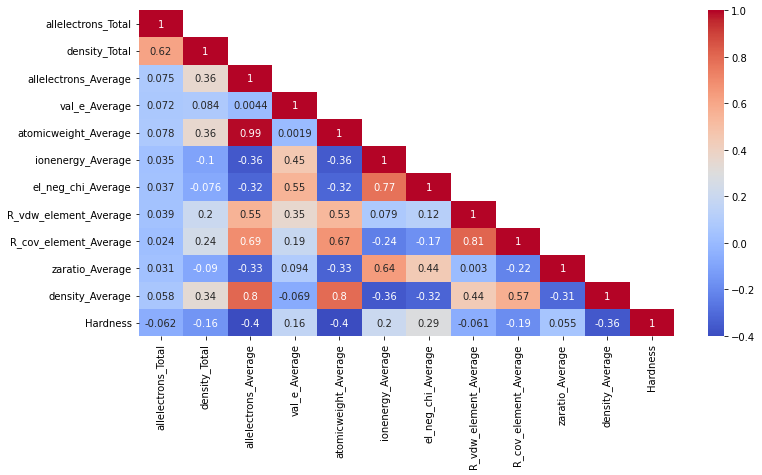

In [44]:
plt.figure(figsize=(12,6))
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm')

In [45]:
features = train.columns.to_list()[:-1]
target = train.columns.to_list().pop(-1)

In [46]:
X = train[features]
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Tree-based Regressors

In [47]:
regressors = {
    "RandomForest": RandomForestRegressor(),
    "XGB": XGBRegressor(),
    "LGBM": LGBMRegressor(),
}

param_map = {
    "RandomForest": {
        'n_estimators': randint(50, 200),
        'max_features': ['sqrt', 'log2'],
        'max_depth': randint(1, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10),
        'bootstrap': [True, False]
    },
    "XGB": {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': randint(1, 10),
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
    },
    "LGBM": {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': randint(1, 10),
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
    },
}


In [49]:
results = {}
best_models = {}
best_params = {}

n_iter_search = 10 
cv_folds = 5        

for name, reg in regressors.items():
    if name in param_map:
        random_search = RandomizedSearchCV(reg, param_distributions=param_map[name],
                                           n_iter=n_iter_search, scoring='neg_mean_absolute_error', cv=cv_folds, 
                                           verbose=1, n_jobs=-1)
        random_search.fit(X_train, y_train)
        
        # Use the best estimator
        best_reg = random_search.best_estimator_
        best_params[name] = random_search.best_params_
    else:
        best_reg = reg
        best_reg.fit(X_train, y_train)
    
    # Predict values
    y_pred = best_reg.predict(X_test)
    
    # Compute MAE
    mae = median_absolute_error(y_test, y_pred)
    
    results[name] = mae
    best_models[name] = best_reg
    print(f"{name} MAE: {mae:.4f}")

# Sort and display results
sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))
print("\nRegressors ranked by MAE:")
for name, mae in sorted_results.items():
    print(f"{name}: {mae:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForest MAE: 0.7073
Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGB MAE: 0.6825
Fitting 5 folds for each of 10 candidates, totalling 50 fits
LGBM MAE: 0.6451

Regressors ranked by MAE:
LGBM: 0.6451
XGB: 0.6825
RandomForest: 0.7073


In [50]:
test = pd.read_csv('data/test.csv')
X_submission = test[features]

In [78]:
preds = []

# for name, reg in best_models.items():
#     print(name)
#     preds.append(reg.predict(X_submission))

# preds = np.array(preds).T

preds = best_models['LGBM'].predict(X_submission)
preds = pd.DataFrame(preds, columns=['target'])

,target
0,2.835108
1,2.667797
2,5.737618
3,4.019566
4,5.398819
...,...
6934,5.896268
6935,4.123152
6936,5.372943
6937,4.837957


In [79]:
submission = pd.concat([test['id'], preds], axis=1)
submission.to_csv('submission.csv', index=False)